In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
cd drive/MyDrive/SIAP/dataset/clean

[Errno 2] No such file or directory: 'drive/MyDrive/SIAP/dataset/clean'
/content/drive/MyDrive/SIAP/dataset/clean


In [121]:
import numpy as np
import pandas as pd
from keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input, MaxPooling1D

from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

from tensorflow.keras.optimizers import Adam

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 15889 
# MAX_VOCAB_SIZE = 10000
# EMBEDDING_DIM = 100
EMBEDDING_DIM = 50

VALIDATION_SPLIT = 0.1
BATCH_SIZE = 128
EPOCHS = 5

In [122]:
train = pd.read_csv('train_clean_removed_emoticons.csv')
sentences = train["Review Text"].fillna("DUMMY_VALUE").values
possible_labels = list(set(train["Rating"]))
y = train["Rating"].values
targets = to_categorical(y)

In [123]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.add('dress')
stop_words.add('petite')
stop_words.add('jacket')
stop_words.add('blazer')

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4 steming kad ubacimo daje losije rezultate
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [124]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
train['Cleaned_Review_Text'] = train['Review Text'].apply(clean_text)

In [125]:
new_str = [str(x) for x in train['Cleaned_Review_Text']]

df = pd.DataFrame(new_str)
temp = []
for i in range(len(df)):
  temp.append(preprocessing(df.iloc[i]))

# Word2Vec model

In [126]:
from gensim.models import Word2Vec

new_str_train = [str(x) for x in train['Cleaned_Review_Text']]
df_train_review_text = pd.DataFrame(new_str_train)

sent = []
for i in range(len(df_train_review_text)):
  sent.append(preprocessing(df_train_review_text.iloc[i]))

model = Word2Vec(sent, min_count=1,size= 50,workers=3, window =3, sg = 1)

# Tokenizing text

In [127]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(temp)
sequences = tokenizer.texts_to_sequences(temp)
s = sorted(len(s) for s in sequences)
word2idx = tokenizer.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
#print("Shape of data tensor:", data.shape)

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)

In [128]:
print(model)

Word2Vec(vocab=15889, size=50, alpha=0.025)


In [129]:
embedding_matrix = model.wv.syn0
print(embedding_matrix)

[[-0.4965048  -0.14213508  0.13577583 ...  0.27958694 -0.01700616
   0.2189054 ]
 [ 0.15980838 -0.7613605   0.735327   ...  0.44513226 -0.23531368
  -0.24264854]
 [-0.2225984  -0.4065195   0.49937534 ...  0.08588147  0.03791106
   0.04481376]
 ...
 [ 0.04420576  0.03279978 -0.04363644 ... -0.0031972   0.04786411
  -0.00173319]
 [-0.00322115 -0.05462748  0.02027263 ...  0.01924331  0.00401779
  -0.0186467 ]
 [ 0.0273743  -0.04512826  0.00863217 ...  0.02556249 -0.0089101
  -0.03449801]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


# Embeding layer

In [130]:
embedding_layer = Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

# CNN Model 

In [131]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# --------------------------------------
x = Conv1D(256, 3, activation="relu")(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation="relu")(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(128, 3, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(possible_labels) + 1, activation="softmax")(x)

model = Model(input_, output)
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.01),
    metrics=["accuracy"],
)

In [132]:
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

Epoch 1/5
128/128 [==============================] - 3s 16ms/step - loss: 1.2825 - accuracy: 0.5502 - val_loss: 1.1479 - val_accuracy: 0.5706
Epoch 2/5
128/128 [==============================] - 2s 13ms/step - loss: 1.1717 - accuracy: 0.5532 - val_loss: 1.1105 - val_accuracy: 0.5717
Epoch 3/5
128/128 [==============================] - 2s 13ms/step - loss: 1.1183 - accuracy: 0.5611 - val_loss: 1.0750 - val_accuracy: 0.5762
Epoch 4/5
128/128 [==============================] - 2s 14ms/step - loss: 1.0763 - accuracy: 0.5727 - val_loss: 1.0520 - val_accuracy: 0.5861
Epoch 5/5
128/128 [==============================] - 2s 13ms/step - loss: 1.0557 - accuracy: 0.5789 - val_loss: 1.0472 - val_accuracy: 0.5872


In [133]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [134]:
print(confusion_matrix(y, y_pred))

[[   0   50  187   39  381]
 [   0   90  371   78  698]
 [   0   94  530  138 1499]
 [   0   28  272  139 3481]
 [   0   14  141  102 9781]]


In [135]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       657
           2       0.33      0.07      0.12      1237
           3       0.35      0.23      0.28      2261
           4       0.28      0.04      0.06      3920
           5       0.62      0.97      0.76     10038

    accuracy                           0.58     18113
   macro avg       0.32      0.26      0.24     18113
weighted avg       0.47      0.58      0.48     18113



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [136]:
print(f1_score(y, y_pred, average="micro"))

0.5819025009661569


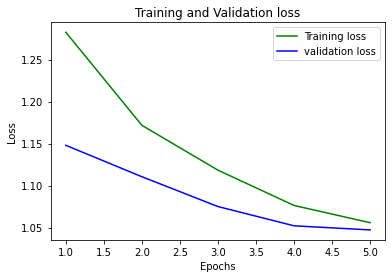

In [137]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

loss_train = r.history['loss']
loss_val = r.history['val_loss']
epochs = range(1,6)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [138]:
test = pd.read_csv('validation_clean_removed_emoticons.csv')
test_text = test["Review Text"].values
test_text = [str(x).lower() for x in test_text]

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

y_test = test["Rating"].values

In [139]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [140]:
print(confusion_matrix(y_test, y_pred))

[[   0    5   19    2   56]
 [   0    8   41    7  101]
 [   0   14   54   25  189]
 [   0    6   36   14  439]
 [   0    3   28   15 1200]]


In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        82
           2       0.22      0.05      0.08       157
           3       0.30      0.19      0.23       282
           4       0.22      0.03      0.05       495
           5       0.60      0.96      0.74      1246

    accuracy                           0.56      2262
   macro avg       0.27      0.25      0.22      2262
weighted avg       0.43      0.56      0.46      2262



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [142]:
print(f1_score(y_test, y_pred, average="micro"))

0.5641025641025641
